# Business Understanding

Thousands of traffic accidents occur in the city of Seattle every year, some of which result in fatalities. The goal of this project is to examine recent traffic collision data and try to predict the severity of any given traffic accident with the intention of making useful recommendations to the city council in hopes that they will implement effective policies like road taxes with the intention of reducing the number of severe traffic accidents.

# Data

In this notebook, we clean and explore the traffic collision data that is stored in "Data-Collisions.csv". Only several features are kept. Features with too many missing entries or are otherwise deemed useless are not kept. Even among the features that are kept, traffic collision entries with missing or NaN values are dropped. Even so, there are still over a hundred thousand entries, enough to do machine learning.

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopy.distance
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("Data-Collisions.csv")
dfUseful = df[['SEVERITYCODE',"X","Y","ADDRTYPE","WEATHER"]]#These are the attributes that I am going to use to build the
#model, as well as the target variable SEVERITYCODE
dfUseful['DateTime'] = pd.to_datetime(df.INCDTTM) #Convert the date and time of incident into datetime object and append as a separate column
dfUseful = dfUseful[(dfUseful['DateTime'].dt.hour !=0 ) | (dfUseful['DateTime'].dt.minute != 0) | (dfUseful['DateTime'].dt.second != 0)] #Some rows were missing the time value and python set their times to be 00:00:00 by default so we are removing these rows

/home/user/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/snap/jupyter/6/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Entries with missing time value have already been removed. Further clean the data by removing entries with NaN values. Remove the rows with "Unknown" and "Other" weather as these provide no information. Since there are many kinds of Weather values, create a new feature titled "Weather Condition" that is "Clear" (which we denote with an integer 0) if "WEATHER" is clear and "Inclement" (which we denote with an integer 1) otherwise.
Create a new feature "Season" based on the DateTime value. Set Winter (December to Feb) as 0, Spring (March to May) as 1, Summer (June to August) as 2,
Fall (September to November) as 3. Also create another feature "Time" also based on the DateTime value with Night (Midnight to 6 am) set to 0, Morning (6 am to Noon) set to 1,
Afternoon (Noon to 6pm) set to 2, and Evening (6pm to Midnight) set to 3. We also assign each pair of coordinates to one of the 7 city districts in Seattle which we label 0 to 6.
The ADDRTYPE feature is also converted into integer values under a new feature 'Address Type' with 0 for 'Block' and 1 for 'Intersection'.

In [2]:
dfUseful=dfUseful.dropna()
dfUseful = dfUseful[dfUseful.WEATHER != "Unknown"] #Remove rows with "Unknown" weather
dfUseful = dfUseful[dfUseful.WEATHER != "Other"]   #Remove rows with "Other" weather
weatherCond = [0 if weath == 'Clear' else 1 for weath in dfUseful.WEATHER]
dfUseful["Weather Condition"] = weatherCond


dfUseful['Season'] = [0 if (x.month % 12 <= 2 ) else 1 if (3 <= x.month % 12 <= 5) else 2 \
                      if (6 <= x.month % 12 <= 8) else 3 for x in dfUseful['DateTime']]
dfUseful['Time'] = [0 if (x.hour <= 5 ) else 1 if (6 <= x.hour <= 11) else 2 \
                      if (12 <= x.hour <= 17) else 3 for x in dfUseful['DateTime']]

districtCoords = [(-122.3868,47.5667),(-122.3009,47.5526),(-122.2865,47.6215),(-122.2903,47.6758)
                  ,(-122.3182,47.7197),(-122.3860,47.6792),(-122.3997,47.6396)] #Array containing coordinates

neighborhood = [] #Empty list for storing the neighborhood values for each pair of coordinates
for i in range(len(dfUseful.index)):
    dist = [geopy.distance.distance((dfUseful.Y.iloc[i], dfUseful.X.iloc[i]),(distCoord[1],distCoord[0])) for distCoord in districtCoords ] #Compute the distance of a given coordinate to each of the 
    neighborhood.append(dist.index(min(dist))) 
dfUseful["Neighborhood"] = neighborhood    

addressType = [0 if i == 'Block' else 1 for i in dfUseful['ADDRTYPE']]
dfUseful['Address Type'] = addressType
dfUseful.head()

dfUseful = dfUseful.drop(['X', 'Y','WEATHER','DateTime','ADDRTYPE'], axis=1)

#districts
#of the approximate center of each city council district
#locator = Nominatim(user_agent='tutorial')
#for i in range(100):
#    try: #Some entries might not have a suburb value so we use a try except clause
#        location = locator.reverse(str(dfUseful.Y.iloc[i])+','+str(dfUseful.X.iloc[i]))
#        print(location.raw['address']['suburb'])
#    except:
#        print('NaN')

# Data Exploration

Having cleaned the data, we perform some preliminary data exploration by making some bar charts to see how accidents with different severities are distributed for each independent variable.

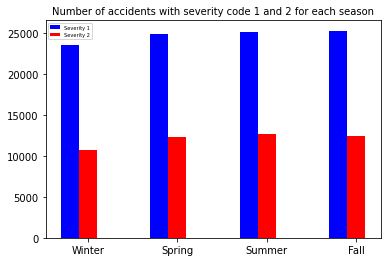

In [3]:
X = np.arange(0,4)
ax = plt.subplot(111)
ax.bar(X-0.2, dfUseful.groupby(['Season','SEVERITYCODE']).size().iloc[::2], width=0.2, color='b', align='center')
ax.bar(X, dfUseful.groupby(['Season','SEVERITYCODE']).size().iloc[1::2], width=0.2, color='r', align='center')
ax.legend(['Severity 1','Severity 2'], prop={'size': 5})

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Number of accidents with severity code 1 and 2 for each season', fontsize=10)

plt.show()

There is little variation in the number of accidents as well as the ratio of more severe accidents to less severe accidents across the seasons.

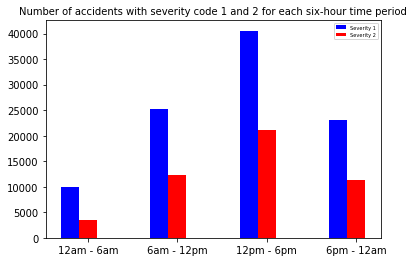

In [5]:
X = np.arange(0,4)
ax = plt.subplot(111)
ax.bar(X-0.2, dfUseful.groupby(['Time','SEVERITYCODE']).size().iloc[::2], width=0.2, color='b', align='center')
ax.bar(X, dfUseful.groupby(['Time','SEVERITYCODE']).size().iloc[1::2], width=0.2, color='r', align='center')
ax.legend(['Severity 1','Severity 2'], prop={'size': 5})

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['12am - 6am','6am - 12pm','12pm - 6pm','6pm - 12am'])
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Number of accidents with severity code 1 and 2 for each six-hour time period', fontsize=10)

plt.show()

The most number of accidents occur in the afternoon from 12pm tp 6pm, while the least number of accidents occur from 12am - 6am. However, we see that the early hours of 12am - 6 am has a greater ratio of less severe accidents to more severe accidents than the other time periods. This is easily explained by the lower amount of traffic at night.

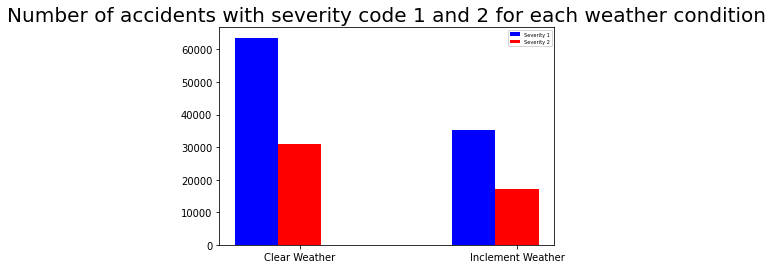

In [6]:
X = np.arange(0,2)
ax = plt.subplot(111)
ax.bar(X-0.2, dfUseful.groupby(['Weather Condition','SEVERITYCODE']).size().iloc[::2], width=0.2, color='b', align='center')
ax.bar(X, dfUseful.groupby(['Weather Condition','SEVERITYCODE']).size().iloc[1::2], width=0.2, color='r', align='center')
ax.legend(['Severity 1','Severity 2'], prop={'size': 5})

ax.set_xticks([0,1])
ax.set_xticklabels(['Clear Weather','Inclement Weather'])
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Number of accidents with severity code 1 and 2 for each weather condition', fontsize=20)

plt.show()

There are a lot more accidents occuring when the weather is clear. This is probably because there are more people driving when the weather is nice and clear than when the weather is not.

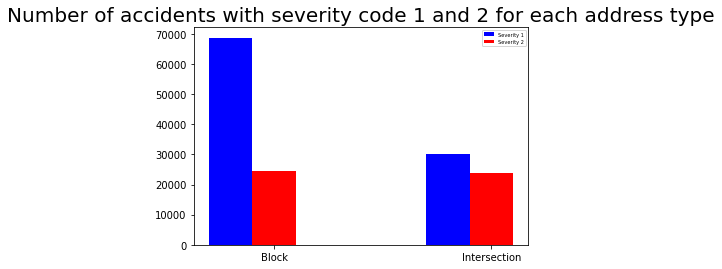

In [13]:
X = np.arange(0,2)
ax = plt.subplot(111)
ax.bar(X-0.2, dfUseful.groupby(['Address Type','SEVERITYCODE']).size().iloc[::2], width=0.2, color='b', align='center')
ax.bar(X, dfUseful.groupby(['Address Type','SEVERITYCODE']).size().iloc[1::2], width=0.2, color='r', align='center')
ax.legend(['Severity 1','Severity 2'], prop={'size': 5})

ax.set_xticks([0,1])
ax.set_xticklabels(['Block','Intersection'])
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Number of accidents with severity code 1 and 2 for each address type', fontsize=20)

plt.show()

We see a very interestin relation between traffic accidents and the address type. While accidents occur at 'Block' with a much higher frequency, they also have a lower fraction of more severe accidents with severity code 2, whereas accidents occuring at an 'Intersection' occur with a lower frequency but with a much larger proportion of severe accidents.

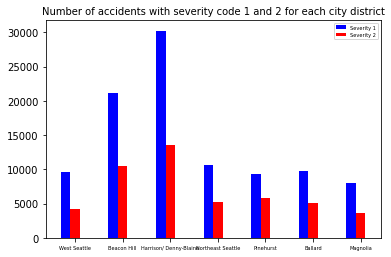

In [50]:
X = np.arange(0,7)
ax = plt.subplot(111)
ax.bar(X-0.2, dfUseful.groupby(['Neighborhood','SEVERITYCODE']).size().iloc[::2], width=0.2, color='b', align='center')
ax.bar(X, dfUseful.groupby(['Neighborhood','SEVERITYCODE']).size().iloc[1::2], width=0.2, color='r', align='center')
ax.legend(['Severity 1','Severity 2'], prop={'size': 5})

#ax.set_xticks([0,2,4,6,8,10,12])
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(['West Seattle','Beacon Hill','Harrison/ Denny-Blaine','Northeast Seattle','Pinehurst','Ballard','Magnolia'])
ax.xaxis.set_tick_params(labelsize=5)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Number of accidents with severity code 1 and 2 for each city district', fontsize=10)

plt.show()

Traffic collisions occur with the highest frequency in districts 2 and 3, which are located on the lower eastern side of Seattle. The ratios of less severe traffic accidents to more severe ones differ greatly from district to district.

# Decision Tree

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

X = dfUseful[['Weather Condition', 'Time', 'Neighborhood', 'Address Type']].values
y = np.asarray(dfUseful['SEVERITYCODE'])

X = X[0:2000,:]
y = y[0:2000]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
decisionTree.fit(X_train,y_train)
predTree = decisionTree.predict(X_test)
print("The f1_score for our Decision Tree is ",f1_score(y_test, predTree, average='weighted'))

The f1_score for our Decision Tree is  0.6253018047135694


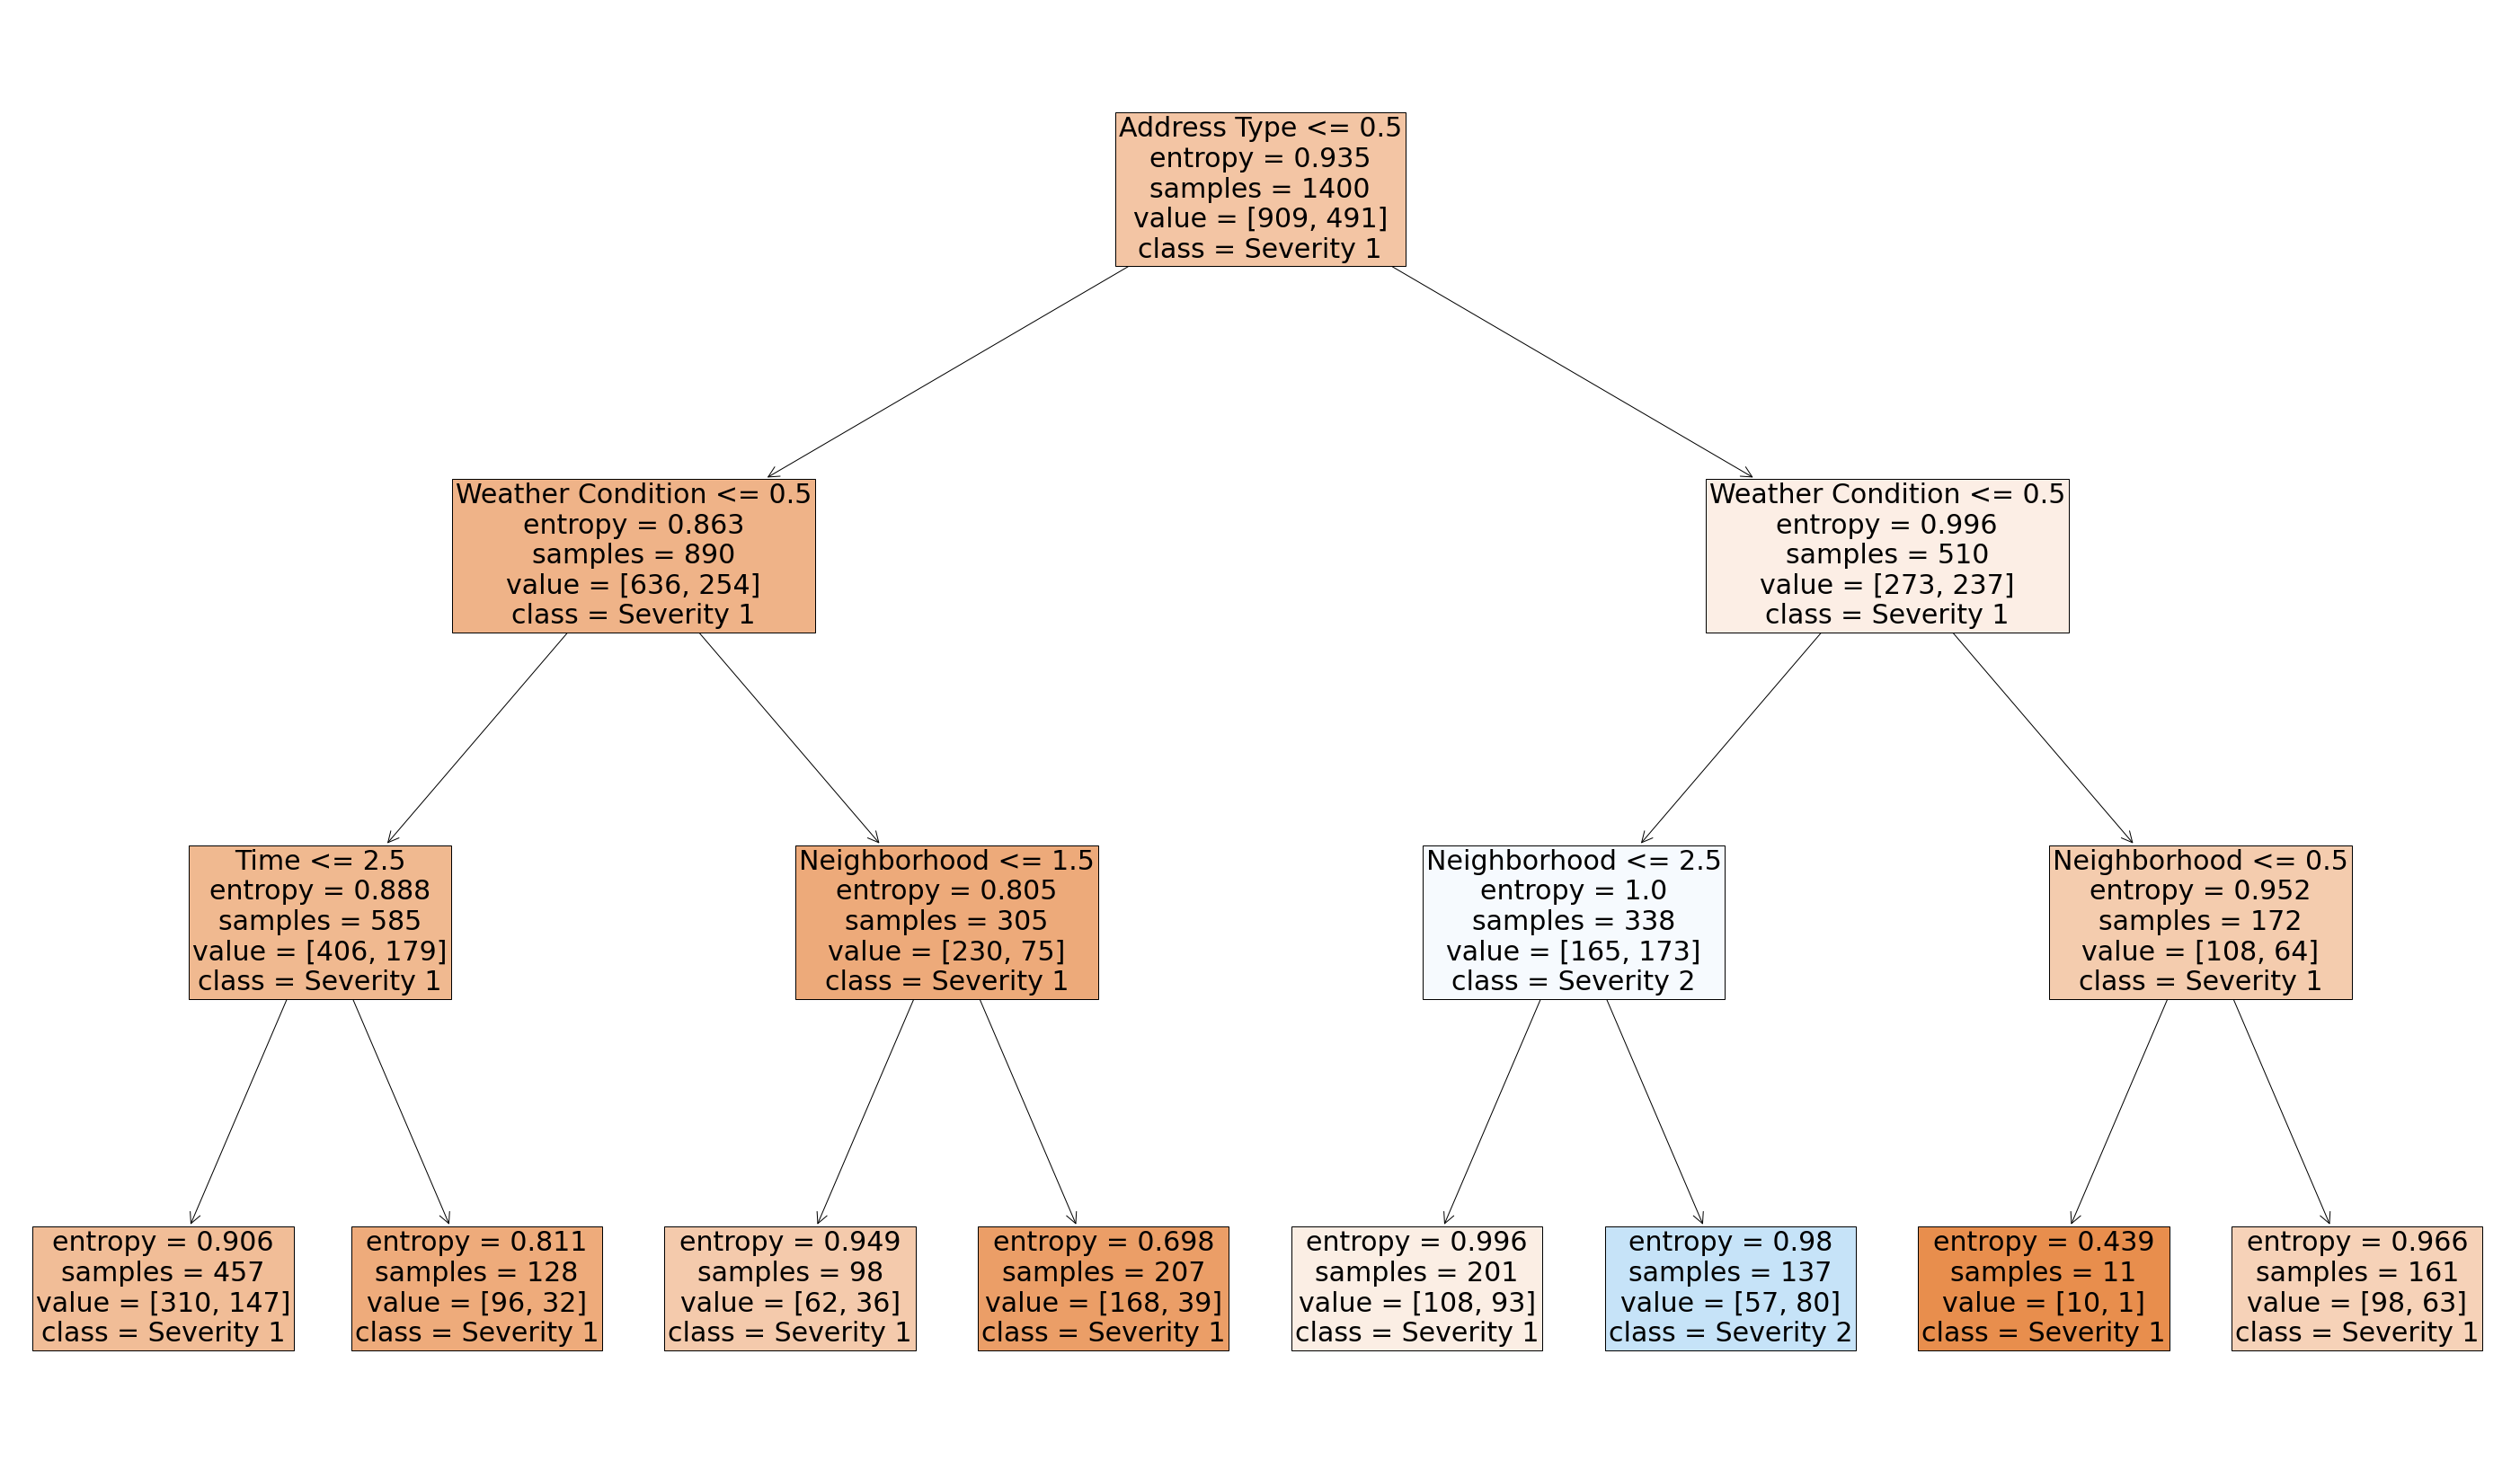

In [14]:
from sklearn import tree

fn=['Weather Condition',  'Time', 'Neighborhood', 'Address Type']
cn=['Severity 1', 'Severity 2']
fig, ax = plt.subplots(figsize=(50, 30))
tree.plot_tree(decisionTree,  fontsize=30,feature_names = fn, 
               class_names=cn,filled = True)
plt.show()

# Logistic Regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

X = dfUseful[['Weather Condition',  'Time', 'Neighborhood', 'Address Type']].values
y = np.asarray(dfUseful['SEVERITYCODE'])
X = X[0:2000,:]
y = y[0:2000]
X = preprocessing.StandardScaler().fit(X).transform(X) #Normalizing the data set

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
f1_score(y_test, yhat, average='weighted')

0.618023307933662

In [5]:
LR.coef_

array([[-0.14145667,  0.01153061,  0.06015815,  0.27887016]])